# UniverSeg trên Dataset U Nang Buồng Trứng (Ovatus)

### Pipeline khám phá dữ liệu
- Load dataset
- Thống kê phân bố nhãn
- Visualize ví dụ điển hình cho từng loại nhãn

In [ ]:
!pip install torch torchvision matplotlib numpy pillow

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

%matplotlib inline

/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Định nghĩa đường dẫn dữ liệu
Thay đổi 2 đường dẫn bên dưới cho phù hợp với máy/Colab của bạn

In [32]:
# THAY ĐỔI THEO MÁY BẠN
DATA_ROOT = "/thiends/hdd2t/UniverSeg/US_map4"                  # Thư mục chứa các folder bệnh nhân
ANNOT_PATH = "/thiends/hdd2t/UniverSeg/mapping_normalized4.jsonl"  # File annotation

RESIZE_TO = (128, 128)

In [33]:
# Paste toàn bộ code từ make_OVatusData.py vào đây (chỉ phần cần thiết)

import json
from torch.utils.data import Dataset
from PIL import Image, ImageDraw

LABEL2ID = {
    "nang_da_thuy": 0,
    "nang_don_thuy": 1,
    "nang_da_thuy_dac": 2,
    "nang_don_thuy_dac": 3,
    "u_bi": 4,
    "u_dac": 5
}
NUM_CLASSES = len(LABEL2ID)
LABEL_NAMES = list(LABEL2ID.keys())

def polygon_to_mask(points, image_size, resize_to=RESIZE_TO):
    mask = Image.new('L', image_size, 0)
    if points is not None and len(points) >= 3:
        ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = mask.resize(resize_to, Image.NEAREST)
    return np.array(mask).astype(np.float32)

def process_image(image_path, resize_to=RESIZE_TO):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(resize_to, Image.BILINEAR)
    img = np.array(img).astype(np.float32) / 255.0
    return np.transpose(img, (2, 0, 1))

class OvatusDataset(Dataset):
    def __init__(self, annot_path=ANNOT_PATH, data_root=DATA_ROOT, resize_to=RESIZE_TO):
        self.samples = []
        print("="*70)
        print("Loading OvatusDataset...")
        print("="*70)

        with open(annot_path, "r", encoding="utf-8") as f:
            for line_idx, line in enumerate(f):
                item = json.loads(line)
                patient = item["patient_name"]

                for img_info in item["images"]:
                    img_name = img_info["image_name"]
                    img_path = os.path.join(data_root, patient, img_name)
                    
                    if not os.path.exists(img_path):
                        continue

                    image_size = (img_info["imageWidth"], img_info["imageHeight"])
                    img = process_image(img_path, resize_to)

                    masks = np.zeros((NUM_CLASSES, resize_to[1], resize_to[0]), dtype=np.float32)

                    labels = img_info["labels"]
                    polygons_list = img_info["points"]
                    
                    has_valid_mask = False
                    for lbl, poly_pts in zip(labels, polygons_list):
                        if lbl not in LABEL2ID:
                            continue
                        class_id = LABEL2ID[lbl]
                        if not poly_pts or len(poly_pts) < 3:
                            continue
                        pts = [tuple(map(float, pt)) for pt in poly_pts]
                        mask = polygon_to_mask(pts, image_size, resize_to)
                        masks[class_id] = np.maximum(masks[class_id], mask)
                        has_valid_mask = True

                    if has_valid_mask:
                        self.samples.append((img, masks, img_path))

        print(f"Loaded {len(self.samples)} images with valid annotations.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, masks, img_path = self.samples[idx]
        return torch.from_numpy(img).float(), torch.from_numpy(masks).float(), img_path

### Load dataset

In [34]:
### Test detect_and_split_dual_view
# Hàm này sẽ được dùng trong load dataset
test_image_path = f"{DATA_ROOT}/167_Nguyễn Thị Hoa/US_2024-11-15 19.49.45.png"

if os.path.exists(test_image_path):
    # Load image
    test_img_pil = Image.open(test_image_path).convert("RGB")
    test_img_resized = test_img_pil.resize(RESIZE_TO, Image.BILINEAR)
    test_img_np = np.array(test_img_resized).astype(np.float32) / 255.0
    test_img_rgb = np.transpose(test_img_np, (2, 0, 1))  # [3, 128, 128]
    
    # Test split
    splits = detect_and_split_dual_view(test_img_rgb)
    
    print(f"✅ Image: {os.path.basename(test_image_path)}")
    print(f"   Detected {len(splits)} part(s): {[s['crop'] for s in splits]}")
    
    # Visualize
    fig, axes = plt.subplots(1, len(splits), figsize=(5*len(splits), 5))
    if len(splits) == 1:
        axes = [axes]
    
    for idx, split_dict in enumerate(splits):
        img_cropped = split_dict['img']
        crop_name = split_dict['crop']
        
        # Convert [C, H, W] -> [H, W, C]
        img_display = np.transpose(img_cropped, (1, 2, 0))
        
        axes[idx].imshow(img_display)
        axes[idx].set_title(f"{crop_name.upper()}\nShape: {img_cropped.shape}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"❌ File not found: {test_image_path}")

❌ File not found: /thiends/hdd2t/UniverSeg/US_map4/167_Nguyễn Thị Hoa/US_2024-11-15 19.49.45.png


In [35]:
dataset = OvatusDataset()
print(f"\nTổng số ảnh có annotation: {len(dataset)}")

Loading OvatusDataset...
Loaded 583 images with valid annotations.

Tổng số ảnh có annotation: 583
Loaded 583 images with valid annotations.

Tổng số ảnh có annotation: 583


### Thống kê phân bố nhãn

In [37]:
label_counts = defaultdict(int)
label_indices = defaultdict(list)

for idx in range(len(dataset)):
    _, masks, _ = dataset[idx]
    for label_idx in range(NUM_CLASSES):
        if masks[label_idx].sum() > 10:  # Có vùng đáng kể
            label_counts[label_idx] += 1
            label_indices[label_idx].append(idx)

print("[INFO] Phân bố nhãn trong toàn bộ dataset:")
for label_idx in range(NUM_CLASSES):
    name = LABEL_NAMES[label_idx]
    count = label_counts[label_idx]
    pct = 100 * count / len(dataset)
    if count >= 100:
        status = "✅ COMMON"
    elif count >= 50:
        status = "✓ MEDIUM"
    elif count >= 20:
        status = "⚠️ RARE"
    else:
        status = "❌ VERY RARE"
    print(f"  [{label_idx}] {name:20s}: {count:3d} ảnh ({pct:5.1f}%) {status}")

[INFO] Phân bố nhãn trong toàn bộ dataset:
  [0] nang_da_thuy        : 151 ảnh ( 25.9%) ✅ COMMON
  [1] nang_don_thuy       : 108 ảnh ( 18.5%) ✅ COMMON
  [2] nang_da_thuy_dac    :  62 ảnh ( 10.6%) ✓ MEDIUM
  [3] nang_don_thuy_dac   :  31 ảnh (  5.3%) ⚠️ RARE
  [4] u_bi                : 116 ảnh ( 19.9%) ✅ COMMON
  [5] u_dac               : 137 ảnh ( 23.5%) ✅ COMMON


### Visualize ví dụ điển hình cho từng loại nhãn
Mỗi nhãn hiển thị tối đa 3 ảnh đại diện


=== NANG_DA_THUY (ID 0) - 151 ảnh ===


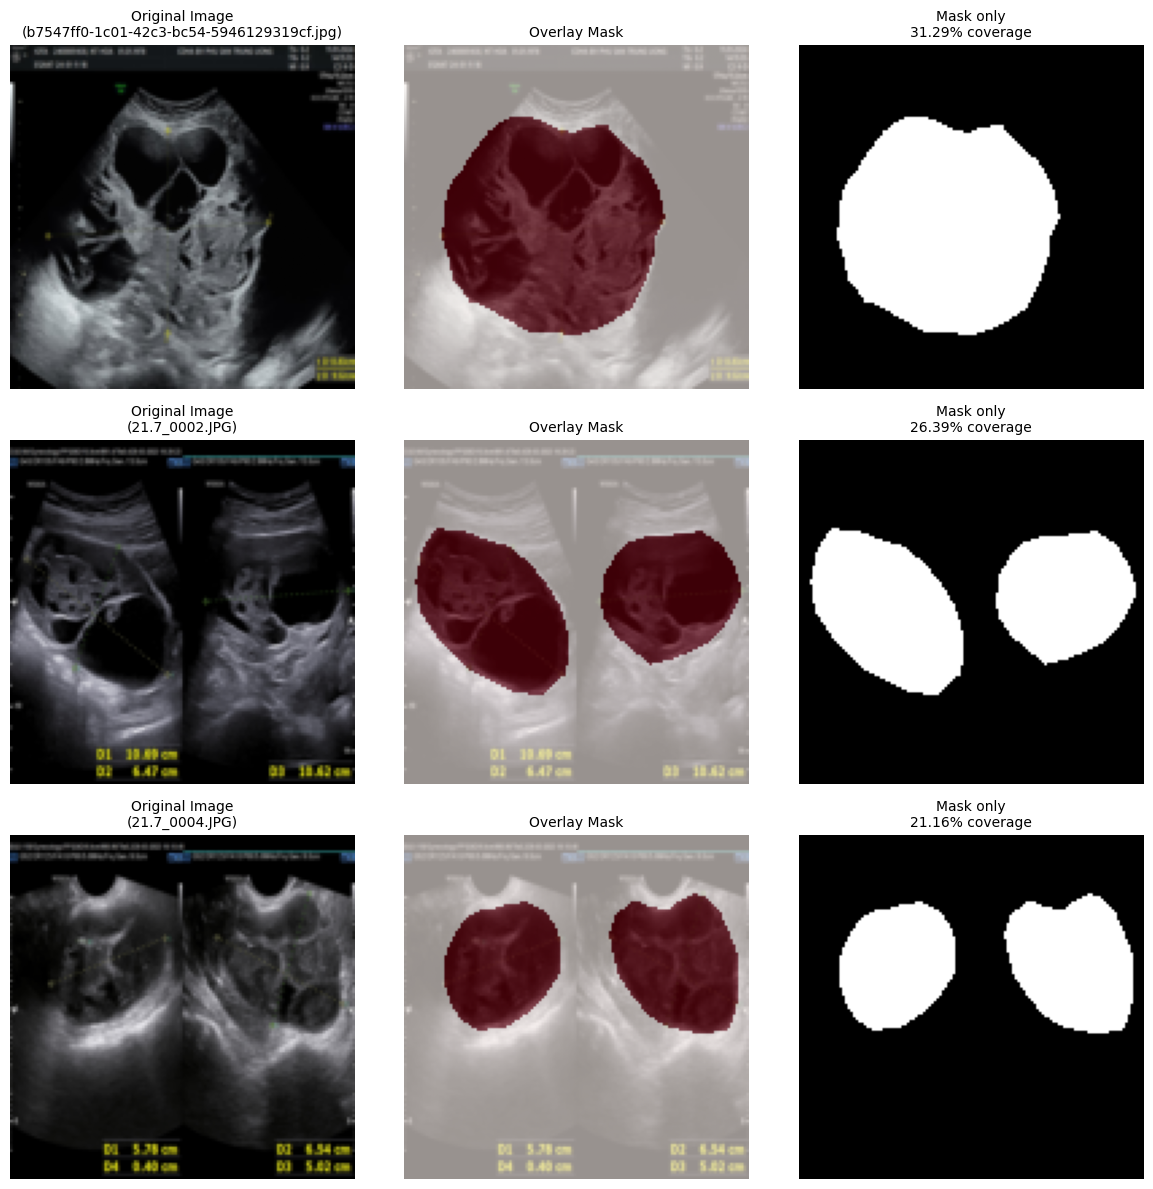


=== NANG_DON_THUY (ID 1) - 108 ảnh ===


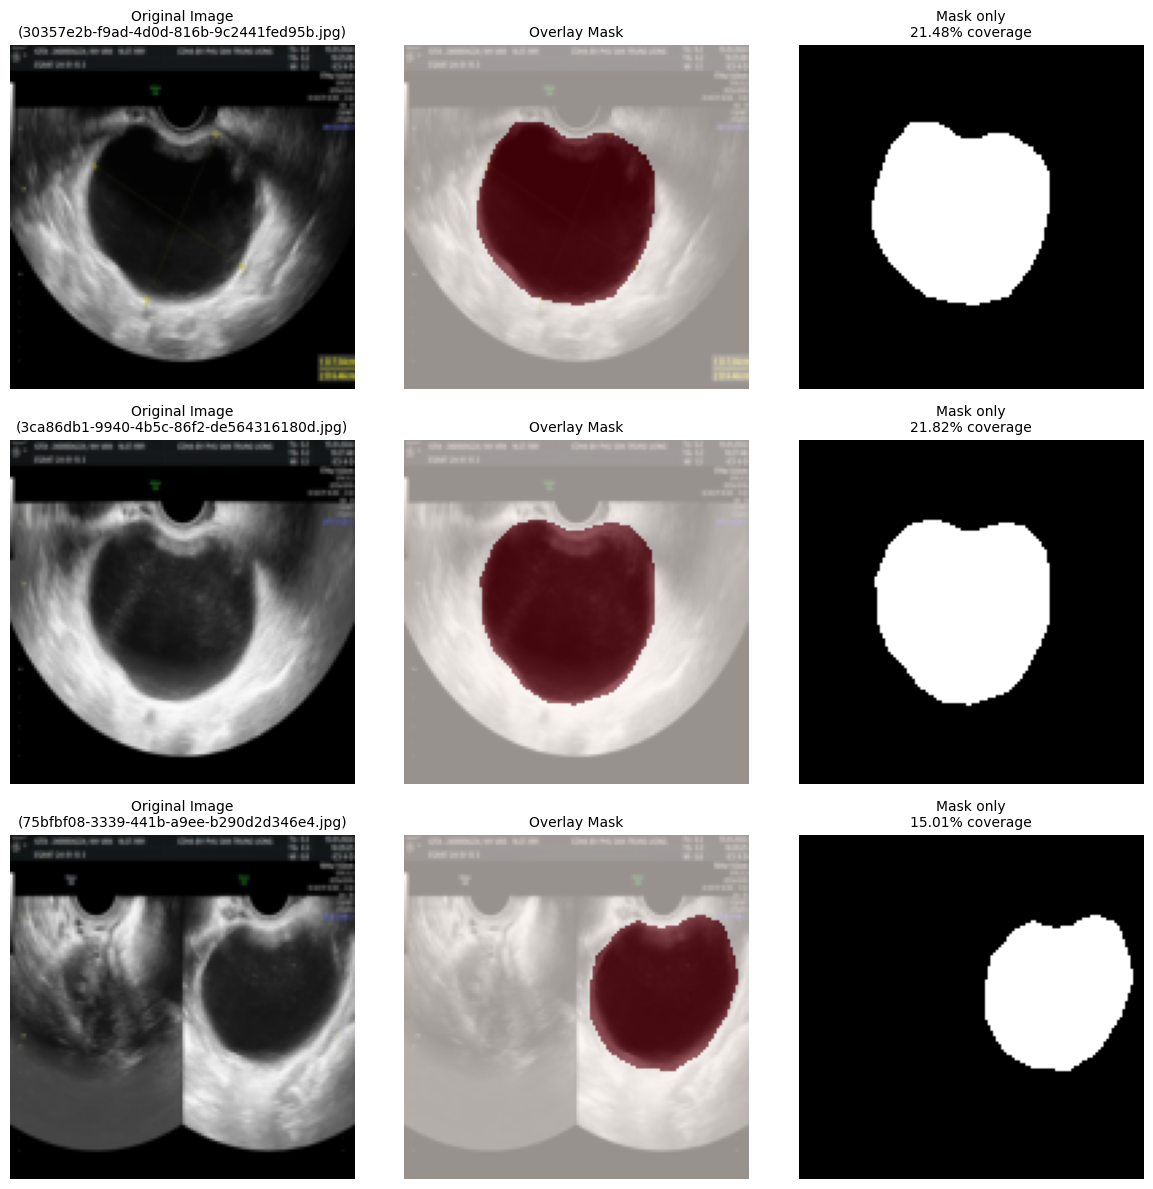


=== NANG_DA_THUY_DAC (ID 2) - 62 ảnh ===


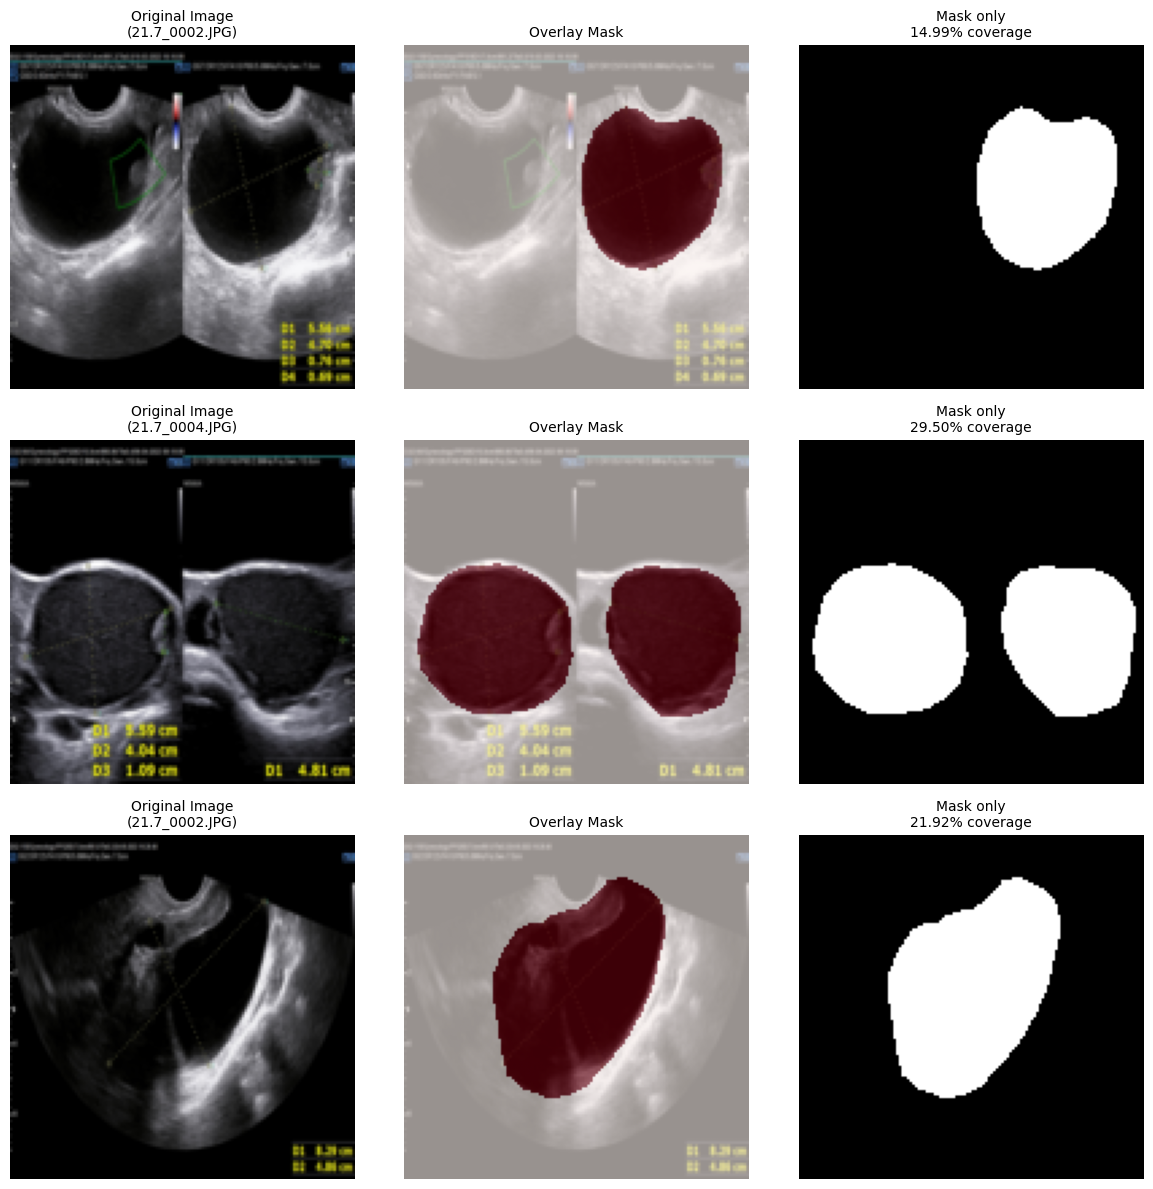


=== NANG_DON_THUY_DAC (ID 3) - 31 ảnh ===


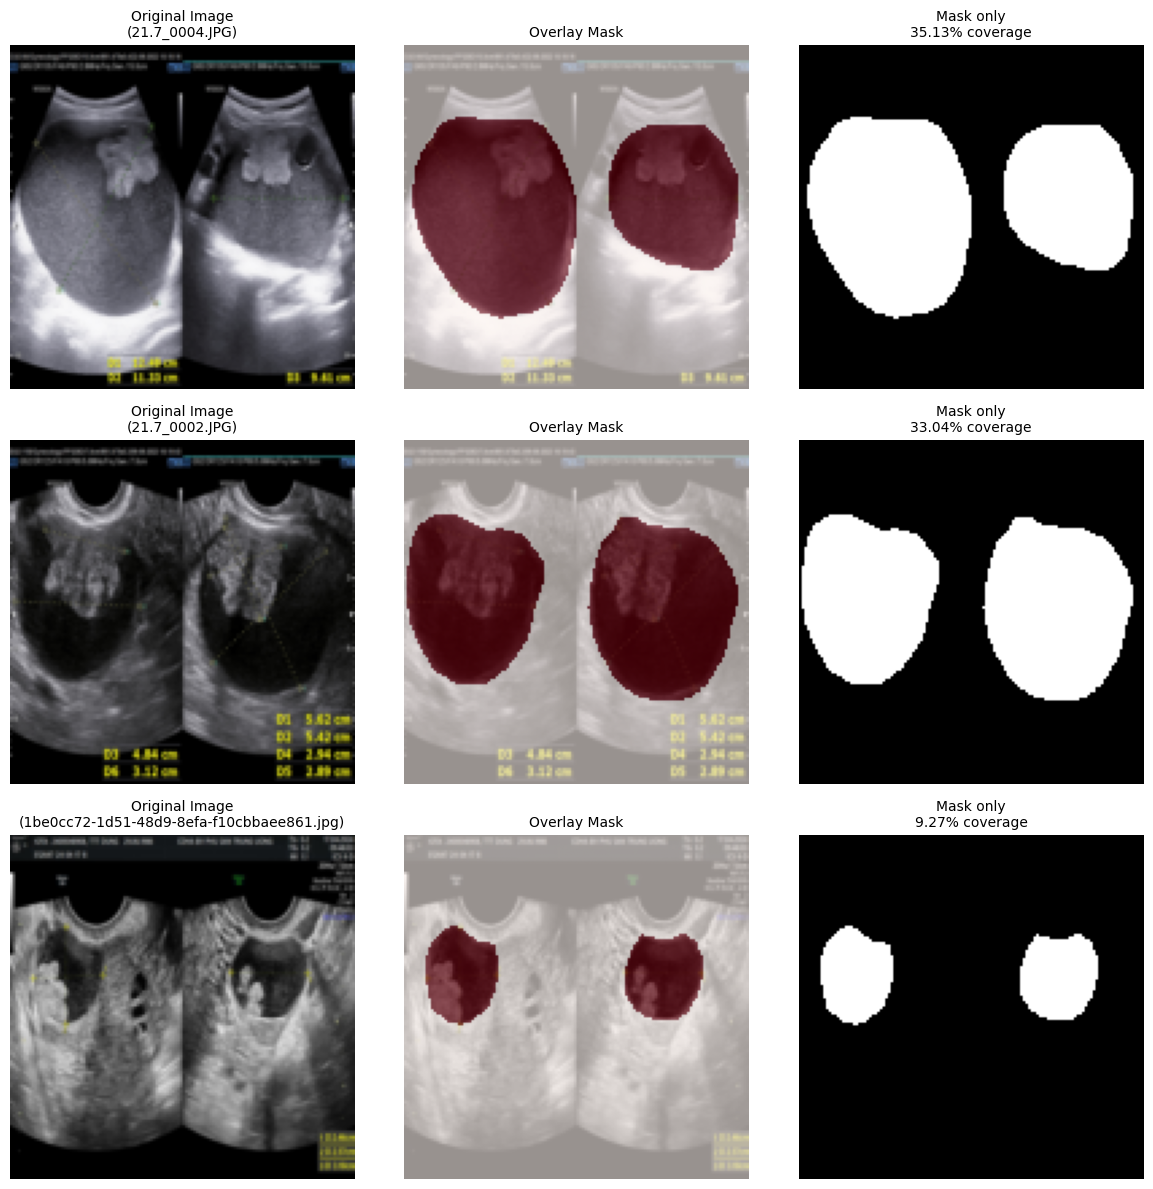


=== U_BI (ID 4) - 116 ảnh ===


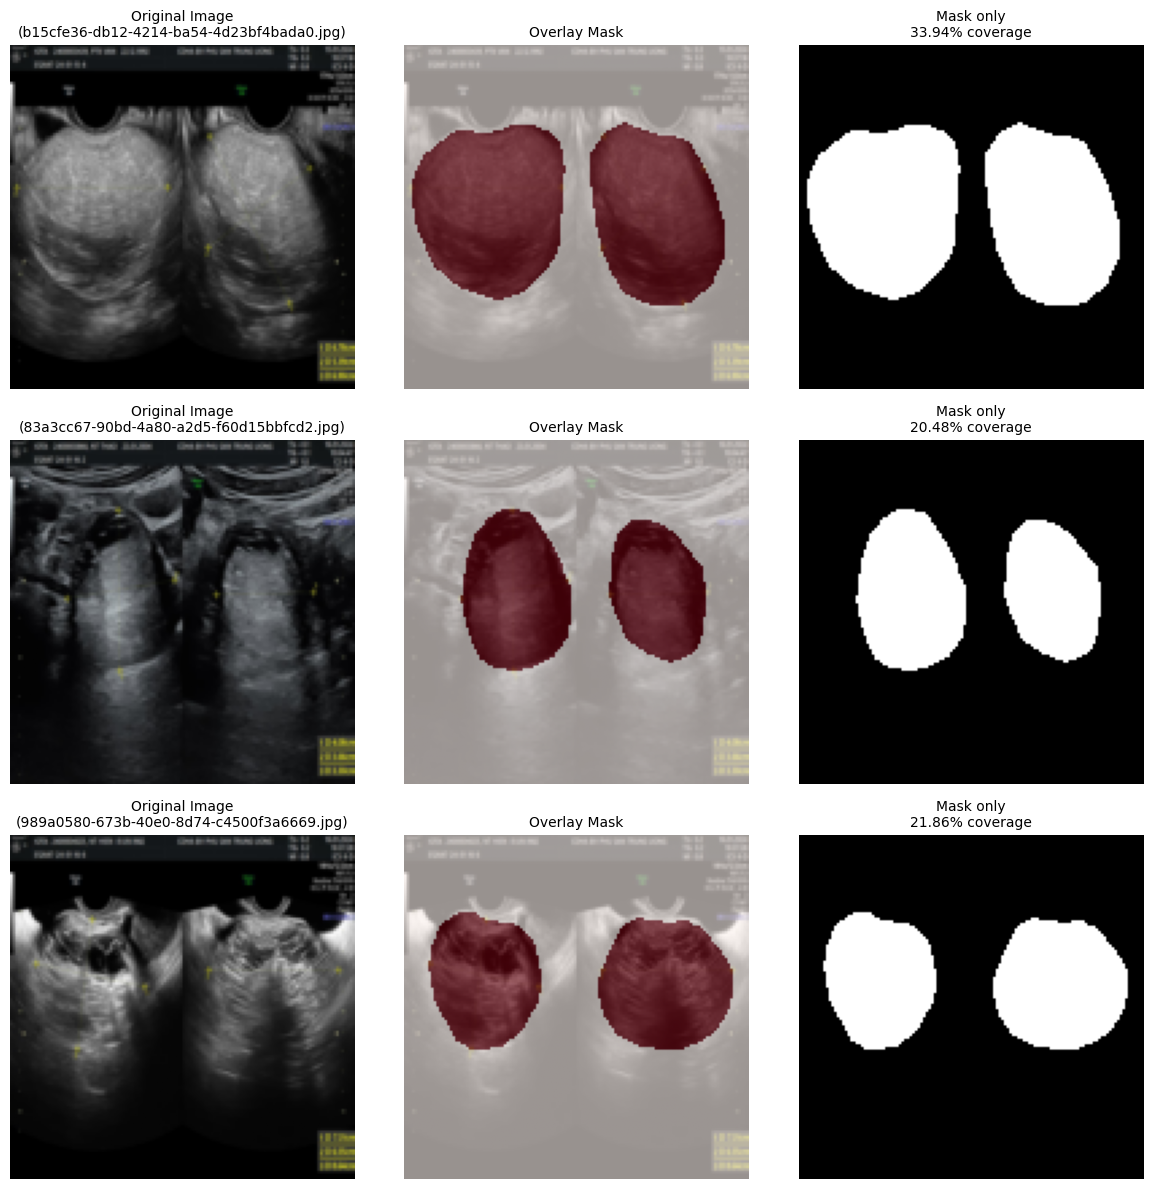


=== U_DAC (ID 5) - 137 ảnh ===


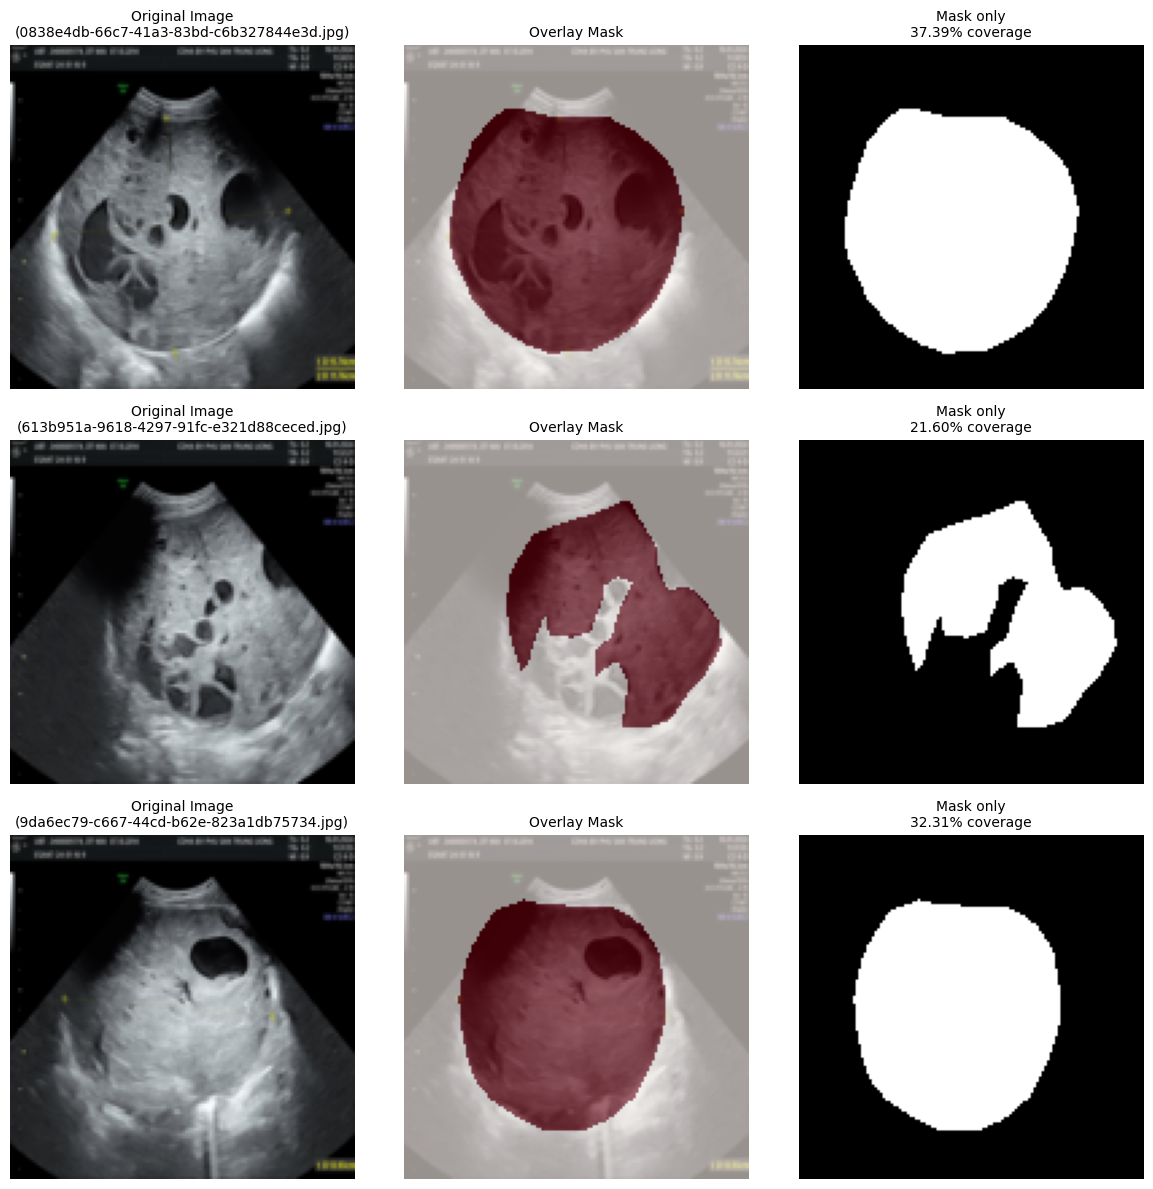

In [40]:
def show_samples_for_label(label_idx, n_show=3):
    name = LABEL_NAMES[label_idx]
    indices = label_indices[label_idx]

    print(f"\n=== {name.upper()} (ID {label_idx}) - {len(indices)} ảnh ===")

    n = min(n_show, len(indices))
    if n == 0:
        print("  → Không có ảnh nào chứa nhãn này.")
        return

    fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

    # Đảm bảo axes luôn là 2D
    if n == 1:
        axes = axes[np.newaxis, :]

    for i in range(n):
        idx = indices[i]
        img, masks, path = dataset[idx]

        # Image: (C,H,W) -> (H,W,C)
        img_rgb = np.transpose(img, (1, 2, 0))

        # Mask cho label hiện tại
        mask = masks[label_idx]

        # Nếu mask là torch.Tensor → chuyển sang CPU
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu()

        # ========== CỘT 1: Original Image ==========
        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title(
            f"Original Image\n({os.path.basename(path)})",
            fontsize=10
        )
        axes[i, 0].axis('off')

        # ========== CỘT 2: Overlay ==========
        axes[i, 1].imshow(img_rgb)
        axes[i, 1].imshow(mask, alpha=0.6, cmap='Reds')
        axes[i, 1].set_title("Overlay Mask", fontsize=10)
        axes[i, 1].axis('off')

        # ========== CỘT 3: Mask only ==========
        axes[i, 2].imshow(mask, cmap='gray')

        # Tính coverage (% pixel thuộc class)
        if isinstance(mask, torch.Tensor):
            coverage = 100.0 * (mask > 0).sum().item() / mask.numel()
        else:
            coverage = 100.0 * (mask > 0).sum() / mask.size

        axes[i, 2].set_title(
            f"Mask only\n{coverage:.2f}% coverage",
            fontsize=10
        )
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# ================== VISUALIZE TỪNG NHÃN ==================
for label_idx in range(NUM_CLASSES):
    if len(label_indices[label_idx]) > 0:
        show_samples_for_label(label_idx, n_show=3)
    else:
        print(f"\n=== {LABEL_NAMES[label_idx].upper()} (ID {label_idx}) - 0 ảnh ===")
        print("  → Không có ảnh nào chứa nhãn này.")

### Tiếp theo
Sau khi xem dữ liệu, bạn có thể tiếp tục với:
- Split patient-level (60/20/20)
- Inference với UniverSeg + adaptive stratified sampling (file infer.py đã có)

In [41]:
# Cell: Phân bố nhãn trong Support Pool (phần quan trọng nhất cho few-shot)

from collections import defaultdict
import numpy as np

print("=== PHÂN BỐ NHÃN TRONG SUPPORT POOL (336 ảnh) ===\n")

label_counts_support = defaultdict(int)
label_indices_support = defaultdict(list)

for idx in range(len(support_pool)):
    _, masks, _ = support_pool[idx]  # masks: torch.Tensor [6, 128, 128]
    for label_idx in range(NUM_CLASSES):
        if masks[label_idx].sum() > 10:  # Có vùng đáng kể
            label_counts_support[label_idx] += 1
            label_indices_support[label_idx].append(idx)

print(f"{'ID':<3} {'Tên nhãn':<25} {'Số ảnh':<6} {'Tỷ lệ':<8} Trạng thái")
print("-" * 60)

total_images = len(support_pool)
for label_idx in sorted(label_counts_support.keys()):
    name = LABEL_NAMES[label_idx]
    count = label_counts_support[label_idx]
    pct = 100 * count / total_images
    
    if count >= 100:
        status = "✅ COMMON"
    elif count >= 60:
        status = "✓ MEDIUM"
    elif count >= 30:
        status = "⚠️ RARE"
    else:
        status = "❌ VERY RARE"
    
    print(f"{label_idx:<3} {name:<25} {count:<6} {pct:5.1f}%   {status}")

# In thêm cảnh báo nếu có class quá hiếm
very_rare = [LABEL_NAMES[i] for i, c in label_counts_support.items() if c < 20]
if very_rare:
    print(f"\n⚠️  CẢNH BÁO: Các class VERY RARE trong support pool: {', '.join(very_rare)}")
    print("   → Cần áp dụng adaptive stratified sampling (như trong infer.py của bạn) để đảm bảo performance!")
else:
    print("\n✅ Tất cả các class đều có đủ ví dụ trong support pool.")

=== PHÂN BỐ NHÃN TRONG SUPPORT POOL (336 ảnh) ===

ID  Tên nhãn                  Số ảnh Tỷ lệ    Trạng thái
------------------------------------------------------------
0   nang_da_thuy              127     27.7%   ✅ COMMON
1   nang_don_thuy             83      18.1%   ✓ MEDIUM
2   nang_da_thuy_dac          49      10.7%   ⚠️ RARE
3   nang_don_thuy_dac         18       3.9%   ❌ VERY RARE
4   u_bi                      92      20.1%   ✓ MEDIUM
5   u_dac                     104     22.7%   ✅ COMMON

⚠️  CẢNH BÁO: Các class VERY RARE trong support pool: nang_don_thuy_dac
   → Cần áp dụng adaptive stratified sampling (như trong infer.py của bạn) để đảm bảo performance!


Using device: cuda

Đang load model UniverSeg pre-trained...
✅ Model loaded!

Bắt đầu inference trên 5 ảnh đầu tiên từ test set (125 ảnh tổng)...

[ 0] Ảnh: 276d05e8-70d9-431b-bed4-62cc41992e46.jpg
     Labels hiện diện: u_bi
     → u_bi                      Dice: 0.822 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.822

     → u_bi                      Dice: 0.822 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.822



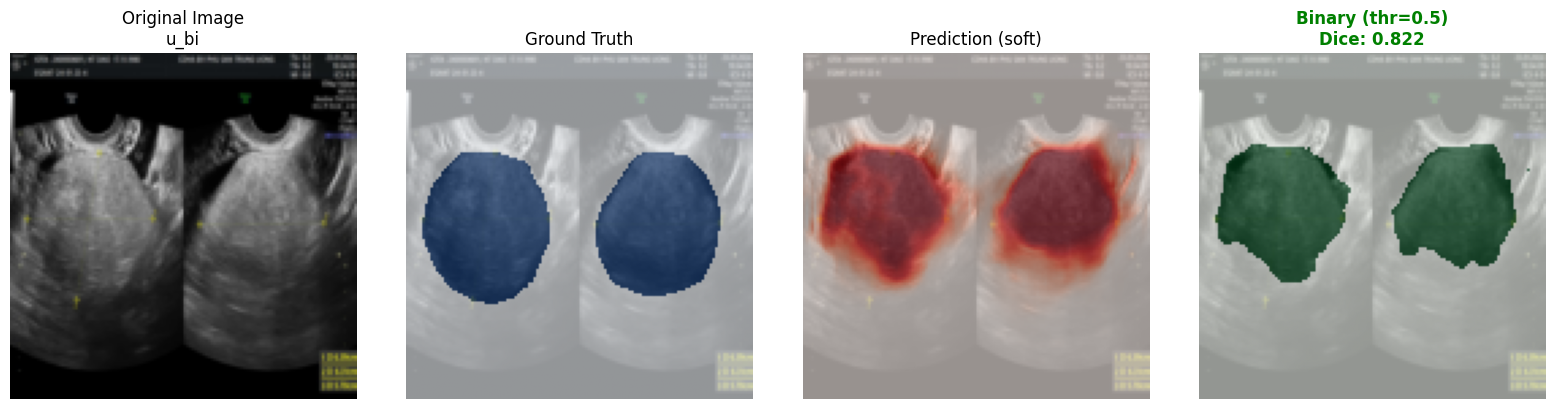

[ 1] Ảnh: 5cefd751-90cf-4efc-a331-3e2f2d1a75d0.jpg
     Labels hiện diện: nang_don_thuy
     → nang_don_thuy             Dice: 0.883 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.883

     → nang_don_thuy             Dice: 0.883 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.883



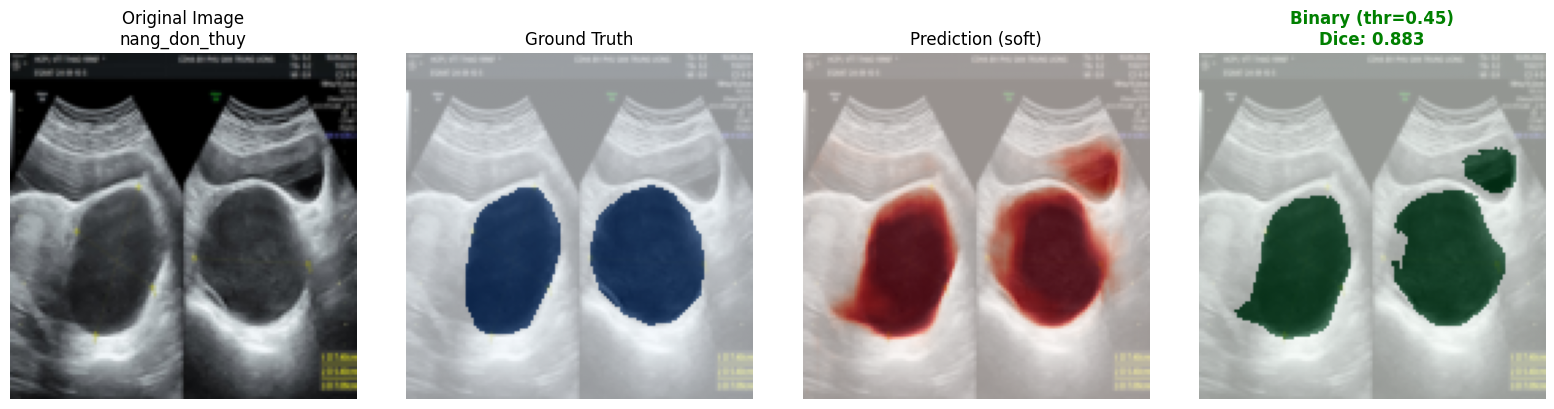

[ 2] Ảnh: 8b108d90-63fd-444d-af1f-4632841f3266.jpg
     Labels hiện diện: nang_don_thuy
     → nang_don_thuy             Dice: 0.877 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.877

     → nang_don_thuy             Dice: 0.877 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.877



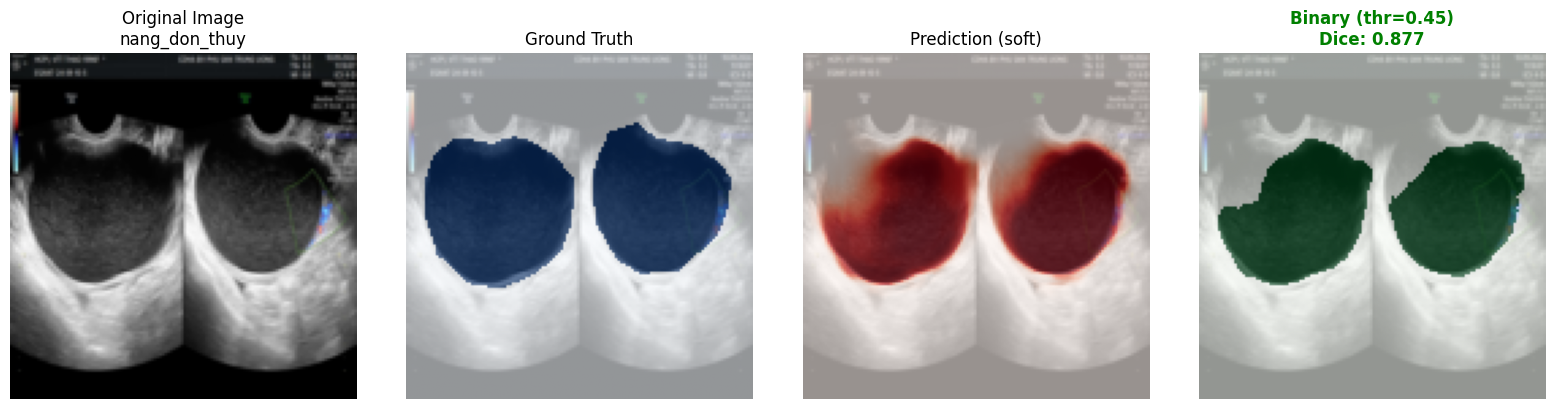

[ 3] Ảnh: 66423dbb-c606-4b76-b473-d7eb9dde62a0.jpg
     Labels hiện diện: u_bi
     → u_bi                      Dice: 0.554 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.554

     → u_bi                      Dice: 0.554 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.554



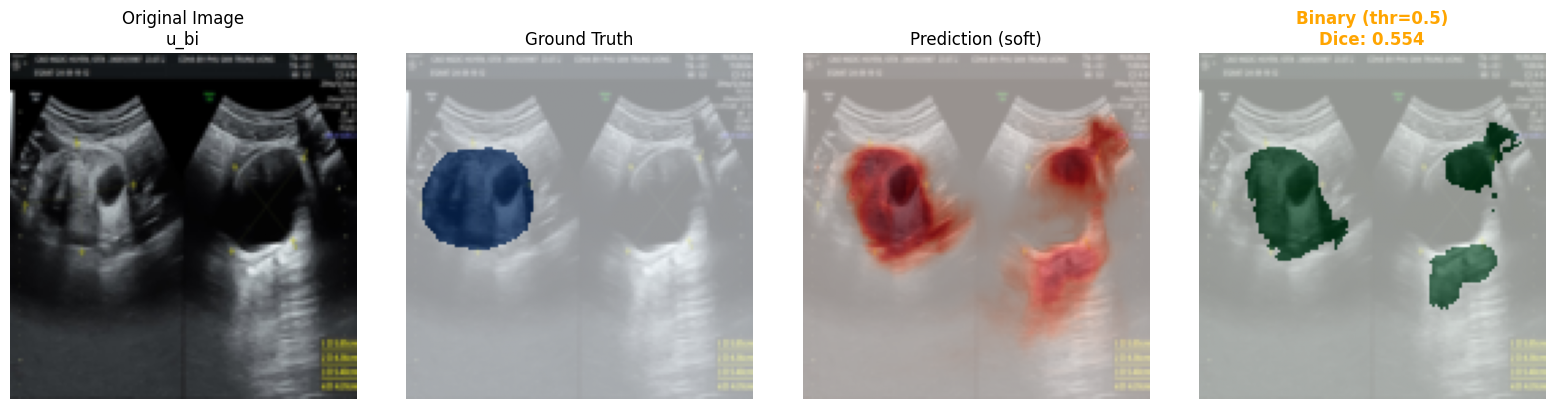

[ 4] Ảnh: 3036bc4d-f951-45f0-a5e8-26296b426d11.jpg
     Labels hiện diện: nang_don_thuy
     → nang_don_thuy             Dice: 0.263 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.263

     → nang_don_thuy             Dice: 0.263 (K=4, target=25/64)
     → Mean Dice ảnh này: 0.263



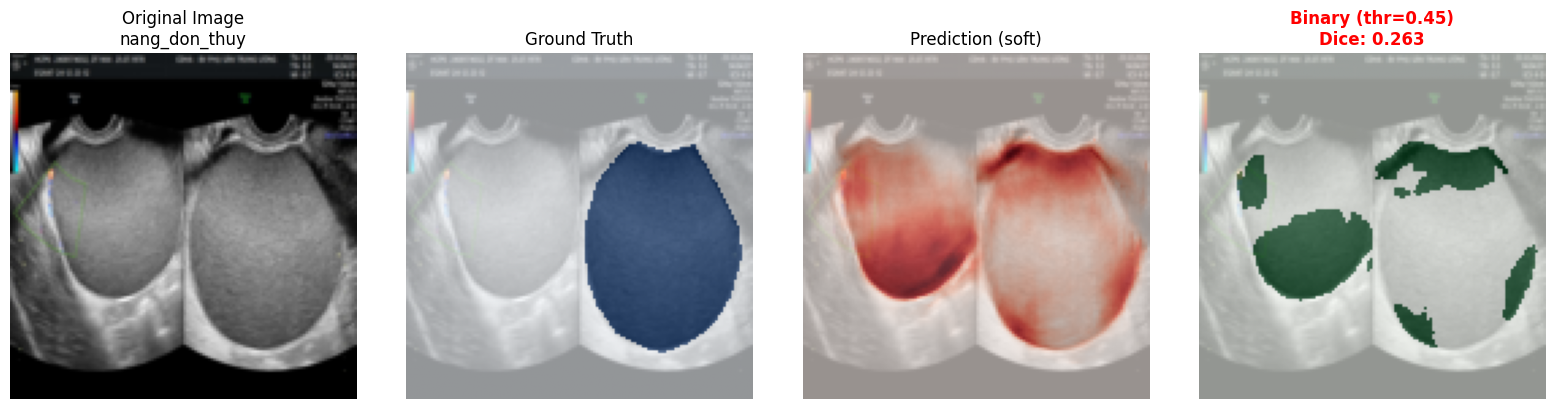

Hoàn tất! Mean Dice trung bình 5 ảnh: 0.680
Visualizations lưu tại: quick_infer_visualizations/


In [42]:
# Cell: Chạy thử inference nhanh UniverSeg trên 5 ảnh test đầu tiên

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from universeg import universeg  # Đảm bảo đã pip install universeg hoặc từ repo

# ================== CONFIG ==================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Load pre-trained UniverSeg
print("\nĐang load model UniverSeg pre-trained...")
model = universeg(pretrained=True).to(DEVICE)
model.eval()
print("✅ Model loaded!")

# Config adaptive đơn giản dựa trên phân bố của bạn
# (support_size, target_examples, ensemble_K)
ADAPTIVE_CONFIG = {
    0: (64, 20, 3),   # nang_da_thuy        COMMON
    1: (64, 25, 4),   # nang_don_thuy       MEDIUM
    2: (64, 35, 6),   # nang_da_thuy_dac    RARE → ưu tiên cao
    3: (32, 16, 10),  # nang_don_thuy_dac   VERY RARE → max ưu tiên
    4: (64, 25, 4),   # u_bi                MEDIUM
    5: (64, 20, 3),   # u_dac               COMMON
}

THRESHOLDS = [0.45, 0.45, 0.40, 0.35, 0.50, 0.40]  # Tune thủ công nếu cần

# ================== HELPER FUNCTIONS ==================
def sample_support(pool, label_indices, target_label, n_total, n_target, seed=42):
    rng = np.random.default_rng(seed)
    target_pool = label_indices[target_label]
    n_target = min(n_target, len(target_pool))
    
    # Lấy target examples (không replace để tránh duplicate)
    target_idxs = rng.choice(target_pool, size=n_target, replace=False).tolist()
    
    # Lấy random từ toàn pool (trừ target đã lấy)
    remaining = n_total - n_target
    available = [i for i in range(len(pool)) if i not in target_idxs]
    random_idxs = rng.choice(available, size=remaining, replace=False).tolist()
    
    final_idxs = target_idxs + random_idxs
    rng.shuffle(final_idxs)
    
    imgs = []
    masks = []
    for i in final_idxs:
        img, mask, _ = pool[i]
        imgs.append(img)
        masks.append(mask[target_label])  # Chỉ lấy channel target label
    
    support_imgs = torch.stack(imgs).to(DEVICE)
    support_masks = torch.stack(masks).unsqueeze(1).to(DEVICE)  # [N,1,H,W]
    return support_imgs.mean(dim=1, keepdim=True), support_masks  # gray

def dice_score(pred, gt, threshold=0.5, smooth=1e-6):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * gt).sum()
    union = pred_bin.sum() + gt.sum()
    return (2. * intersection + smooth) / (union + smooth)

# ================== INFERENCE TRÊN 5 ẢNH TEST ==================
print(f"\nBắt đầu inference trên 5 ảnh đầu tiên từ test set ({len(test_set)} ảnh tổng)...\n")

VIS_SAVE_DIR = "quick_infer_visualizations"
os.makedirs(VIS_SAVE_DIR, exist_ok=True)

overall_dices = []

for test_idx in range(min(5, len(test_set))):
    query_img, query_gt, img_path = test_set[test_idx]
    query_img = query_img.to(DEVICE)  # [3,128,128]
    query_gt = query_gt.to(DEVICE)    # [6,128,128]
    query_gray = query_img.mean(dim=0, keepdim=True).unsqueeze(0)  # [1,1,128,128]
    
    # Tìm các label có trong ảnh này
    valid_labels = [i for i in range(6) if query_gt[i].sum() > 10]
    if not valid_labels:
        print(f"[{test_idx}] Skip - không có label nào")
        continue
    
    print(f"[{test_idx:2d}] Ảnh: {os.path.basename(img_path)}")
    print(f"     Labels hiện diện: {', '.join([LABEL_NAMES[i] for i in valid_labels])}")
    
    final_preds = torch.zeros_like(query_gt)
    sample_dices = []
    
    for label_idx in valid_labels:
        cfg = ADAPTIVE_CONFIG[label_idx]
        n_total, n_target, K = cfg
        
        preds = []
        for k in range(K):
            seed = 42 + test_idx * 100 + label_idx * 10 + k
            sup_imgs, sup_masks = sample_support(
                support_pool, label_indices_support, label_idx,
                n_total, n_target, seed
            )
            
            with torch.no_grad():
                logit = model(query_gray, sup_imgs.unsqueeze(0), sup_masks.unsqueeze(0))
                prob = torch.sigmoid(logit)[0,0]  # [128,128]
                preds.append(prob)
        
        avg_pred = torch.mean(torch.stack(preds), dim=0)
        final_preds[label_idx] = avg_pred
        
        thresh = THRESHOLDS[label_idx]
        dice = dice_score(avg_pred, query_gt[label_idx], thresh).item()
        sample_dices.append(dice)
        print(f"     → {LABEL_NAMES[label_idx]:25} Dice: {dice:.3f} (K={K}, target={n_target}/{n_total})")
    
    mean_dice = np.mean(sample_dices)
    overall_dices.append(mean_dice)
    print(f"     → Mean Dice ảnh này: {mean_dice:.3f}\n")
    
    # ================== VISUALIZE ==================
    fig, axes = plt.subplots(len(valid_labels), 4, figsize=(16, 4*len(valid_labels)))
    if len(valid_labels) == 1:
        axes = axes[np.newaxis, :]
    
    rgb = query_img.permute(1,2,0).cpu().numpy()
    
    for row, lbl in enumerate(valid_labels):
        name = LABEL_NAMES[lbl]
        gt = query_gt[lbl].cpu().numpy()
        pred = final_preds[lbl].cpu().numpy()
        thresh = THRESHOLDS[lbl]
        pred_bin = (pred > thresh)
        
        axes[row,0].imshow(rgb)
        axes[row,0].set_title(f"Original Image\n{name}", fontsize=12)
        axes[row,0].axis('off')
        
        axes[row,1].imshow(rgb)
        axes[row,1].imshow(gt, alpha=0.6, cmap='Blues')
        axes[row,1].set_title("Ground Truth", fontsize=12)
        axes[row,1].axis('off')
        
        axes[row,2].imshow(rgb)
        axes[row,2].imshow(pred, alpha=0.6, cmap='Reds')
        axes[row,2].set_title("Prediction (soft)", fontsize=12)
        axes[row,2].axis('off')
        
        axes[row,3].imshow(rgb)
        axes[row,3].imshow(pred_bin, alpha=0.6, cmap='Greens')
        color = 'green' if sample_dices[row] > 0.7 else 'orange' if sample_dices[row] > 0.5 else 'red'
        axes[row,3].set_title(f"Binary (thr={thresh})\nDice: {sample_dices[row]:.3f}", 
                              fontsize=12, color=color, weight='bold')
        axes[row,3].axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(VIS_SAVE_DIR, f"test_{test_idx:03d}_dice_{mean_dice:.3f}.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print(f"Hoàn tất! Mean Dice trung bình 5 ảnh: {np.mean(overall_dices):.3f}")
print(f"Visualizations lưu tại: {VIS_SAVE_DIR}/")

In [43]:
# ================== CELL: Infer test set + save visualization (same format as sample) ==================

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

VIS_SAVE_DIR = "infer_testset"
os.makedirs(VIS_SAVE_DIR, exist_ok=True)

print(f"\n📁 Lưu visualization tại: {VIS_SAVE_DIR}/")
model.eval()

all_image_dices = []

with torch.no_grad():
    for test_idx in tqdm(range(len(test_set)), desc="Infer + Save vis"):
        query_img, query_gt, img_path = test_set[test_idx]

        query_img = query_img.to(DEVICE)          # [3,H,W]
        query_gt = query_gt.to(DEVICE)            # [C,H,W]
        query_gray = query_img.mean(dim=0, keepdim=True).unsqueeze(0)

        # tìm label xuất hiện
        valid_labels = [i for i in range(NUM_CLASSES) if query_gt[i].sum() > 10]
        if not valid_labels:
            continue

        final_preds = torch.zeros_like(query_gt)
        sample_dices = []

        for label_idx in valid_labels:
            n_total, n_target, K = ADAPTIVE_CONFIG[label_idx]
            preds = []

            for k in range(K):
                seed = 1000 + test_idx * 100 + label_idx * 10 + k
                sup_imgs, sup_masks = sample_support(
                    support_pool,
                    label_indices_support,
                    label_idx,
                    n_total,
                    n_target,
                    seed
                )

                logit = model(
                    query_gray,
                    sup_imgs.unsqueeze(0),
                    sup_masks.unsqueeze(0)
                )
                prob = torch.sigmoid(logit)[0, 0]
                preds.append(prob)

            avg_pred = torch.mean(torch.stack(preds), dim=0)
            final_preds[label_idx] = avg_pred

            dice = dice_score(
                avg_pred,
                query_gt[label_idx],
                threshold=THRESHOLDS[label_idx]
            ).item()
            sample_dices.append(dice)

        mean_dice = np.mean(sample_dices)
        all_image_dices.append(mean_dice)

        # ================== VISUALIZE (GIỐNG CODE MẪU) ==================
        fig, axes = plt.subplots(len(valid_labels), 4, figsize=(16, 4 * len(valid_labels)))
        if len(valid_labels) == 1:
            axes = axes[np.newaxis, :]

        rgb = query_img.permute(1, 2, 0).cpu().numpy()

        for row, lbl in enumerate(valid_labels):
            name = LABEL_NAMES[lbl]
            gt = query_gt[lbl].cpu().numpy()
            pred = final_preds[lbl].cpu().numpy()
            thresh = THRESHOLDS[lbl]
            pred_bin = pred > thresh

            axes[row, 0].imshow(rgb)
            axes[row, 0].set_title(f"Original Image\n{name}", fontsize=12)
            axes[row, 0].axis("off")

            axes[row, 1].imshow(rgb)
            axes[row, 1].imshow(gt, alpha=0.6, cmap="Blues")
            axes[row, 1].set_title("Ground Truth", fontsize=12)
            axes[row, 1].axis("off")

            axes[row, 2].imshow(rgb)
            axes[row, 2].imshow(pred, alpha=0.6, cmap="Reds")
            axes[row, 2].set_title("Prediction (soft)", fontsize=12)
            axes[row, 2].axis("off")

            color = "green" if sample_dices[row] > 0.7 else "orange" if sample_dices[row] > 0.5 else "red"
            axes[row, 3].imshow(rgb)
            axes[row, 3].imshow(pred_bin, alpha=0.6, cmap="Greens")
            axes[row, 3].set_title(
                f"Binary (thr={thresh})\nDice: {sample_dices[row]:.3f}",
                fontsize=12,
                color=color,
                weight="bold"
            )
            axes[row, 3].axis("off")

        plt.tight_layout()

        base_name = os.path.splitext(os.path.basename(img_path))[0]
        save_path = os.path.join(
            VIS_SAVE_DIR,
            f"{base_name}_dice_{mean_dice:.3f}.png"
        )
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close(fig)

print("\n✅ Hoàn tất!")
print(f"📊 Mean Dice toàn test set: {np.mean(all_image_dices):.4f}")
print(f"🖼️ Ảnh visualization đã lưu trong: {VIS_SAVE_DIR}/")



📁 Lưu visualization tại: infer_testset/


Infer + Save vis: 100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


✅ Hoàn tất!
📊 Mean Dice toàn test set: 0.6581
🖼️ Ảnh visualization đã lưu trong: infer_testset/
